In [11]:
import ROOT
import uproot
import matplotlib.pyplot as plt

import numpy as np


In [12]:
#Tensione di Saturazione
Vt = -1.25 #V


In [13]:
#Carico le due Run Segnale per il canale 2
RunCs = uproot.open('../Dati/Run_ch2_Cs_Measurements_Only_3_21_2024.root')
RunCsBis = uproot.open('../Dati/Run_ch2_Cs_Measurements_Only_3_21_2024_BIS.root')

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
chargeCsBis = np.array(RunCsBis['tree'].arrays()['charge'])

ampCs = np.array(RunCs['tree'].arrays()['amp'])
ampCsBis = np.array(RunCsBis['tree'].arrays()['amp'])

chargeCs = np.append(chargeCs,chargeCsBis)
ampCs = np.append(ampCs,ampCsBis)


#Carico le due Run Noise per il canale 2
RunNoise = uproot.open('../Dati/Run_ch2_X_Measurements_Only_3_21_2024.root')
RunNoiseBis = uproot.open('../Dati/Run_ch2_X_Measurements_Only_3_21_2024_BIS.root')

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
chargeNBis = np.array(RunNoiseBis['tree'].arrays()['charge'])

ampN = np.array(RunNoise['tree'].arrays()['amp'])
ampNBis = np.array(RunNoiseBis['tree'].arrays()['amp'])

chargeN = np.append(chargeN,chargeNBis)
ampN = np.append(ampN,ampNBis)


#calcolo il numero di eventi totali
evCs = np.array(RunCs['tree'].arrays()['ev'])[-1]
evCsBis = np.array(RunCsBis['tree'].arrays()['ev'])[-1]
evCsT = evCs+evCsBis

evN = np.array(RunNoise['tree'].arrays()['ev'])[-1]
evNBis = np.array(RunNoiseBis['tree'].arrays()['ev'])[-1]
evNT = evN+evNBis

print("il numero di eventi di rumore e':",round(evNT))
print("il numero di eventi di rumore e':",round(evCsT))


#leggo il tempo di acquisizione dal file
TCs = 428 #s
TN = 642 #s

#calcolo la rate dei processi

rateCs = evCsT/TCs
rateN = evNT/TN


BalancedEv = TCs*rateN
print("la rate del segnale e':",round(rateCs,2))
print("la rate del rumore e'",round(rateN,2))
print("Il numero corretto di seganale da tenere in considerazione e'",BalancedEv)


il numero di eventi di rumore e': 150000
il numero di eventi di rumore e': 200000
la rate del segnale e': 467.29
la rate del rumore e' 233.64
Il numero corretto di seganale da tenere in considerazione e' 100000.0


In [14]:

#rimuovo gli eventi che saturano
trueCs = ampCs>Vt
chargeCs = chargeCs[trueCs]

trueX = ampN>Vt
chargeN = chargeN[trueX]



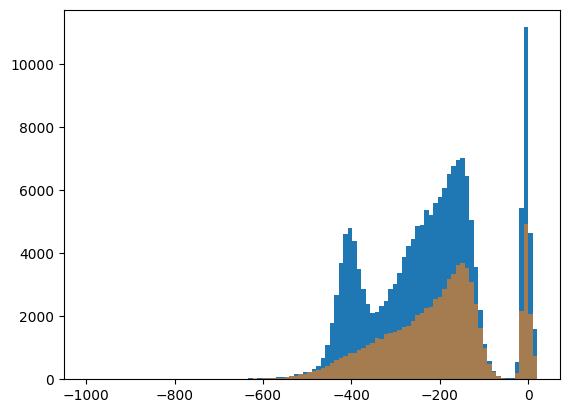

In [18]:
bin = 100


bin1,edge1,_ = plt.hist(chargeCs, bins=bin, range=(-1000,20))
bin2,edge2,_= plt.hist(chargeN[:BalancedEv.astype(int)], bins=bin, range=(-1000,20), alpha=0.6)
#plt.savefig('hist1_40.pdf')

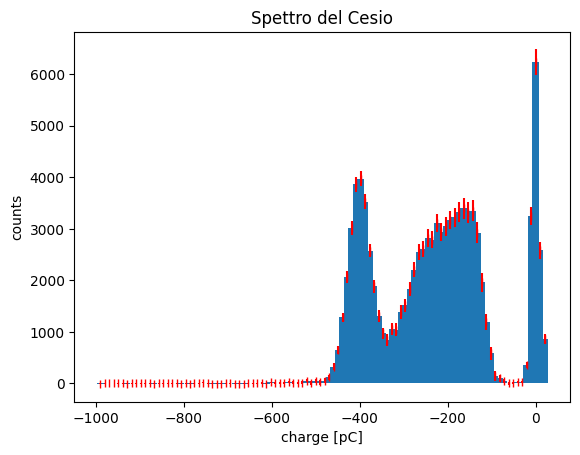

In [23]:


#ricostruzione dello spettro



plt.bar(edge2[1:],bin1-bin2,width=15)
err=np.sqrt(bin1+bin2)
plt.errorbar(edge2[1:], bin1-bin2, err*2, color='red', fmt='|')
plt.title("Spettro del Cesio")
plt.ylabel("counts")
plt.xlabel("charge [pC]")
plt.savefig("../Fig/SpettroSchifo.pdf")